# Fun stuff


In [24]:
import urllib2
import json
import unicodedata
import re
import networkx as nx
from colour import Color

In [2]:
def fetch_characters():
    baseurl = "https://en.wikipedia.org/w/api.php?"
    action = "action=query"
    title = "titles=List_of_Star_Wars_characters"
    content = "prop=revisions"
    rvprop ="rvprop=timestamp|content"
    dataformat = "format=json"
    rvdir = "rvdir=older" #sort revisions from newest to oldest
    end = "rvend=2000-01-03T00:00:00Z" #start of my time period
    start = "rvstart=2019-01-03T00:00:00Z" #end of my time period
    limit = "rvlimit=1" #consider only the first revision

    query = "%s%s&%s&%s&%s&%s&%s&%s&%s&%s" % \
    (baseurl, action, title, content, rvprop, dataformat, rvdir, end, start, limit)
    response = urllib2.urlopen(query)
    wikisource = response.read()
    wikijson = json.loads(wikisource)
    wikiid = wikijson["query"]["pages"].keys()[0]
    text = wikijson["query"]["pages"][wikiid]["revisions"][-1]["*"]
    # All characters on this page match the regex below
    regex = "\{\{visible anchor\|(.*?)\}\}"
    chars = re.findall(regex,text)
    characters = []
    for c in chars :
        for s in c.split("|") :
            st = ((s.replace("[", "")).replace("]","")).replace(" ","_")
            # prefix/suffix fixes
            if (st.startswith("Admiral_")):
                st = st[8:]
            st = st.replace("_(Star_Wars)", "")
            #char = unicodedata.normalize('NFKD', st).encode('ascii','ignore')
            characters.append(st)   
    # Anakin skywalker is a special case
    characters.append("Anakin_Skywalker")
    return set(characters)


def fetch_wiki_article(title_):
    baseurl = "http://starwars.wikia.com/api.php?"
    action = "action=query"
    title = "titles=" + title_ + "&&redirects" # Redirects are gods gift to man
    title = title.encode("utf-8") # This is our fix for unicode problems
    content = "prop=revisions"
    rvprop ="rvprop=timestamp|content"
    dataformat = "format=json"
    rvdir = "rvdir=older" #sort revisions from newest to oldest
    end = "rvend=2000-01-03T00:00:00Z" #start of my time period
    start = "rvstart=2019-01-03T00:00:00Z" #end of my time period
    limit = "rvlimit=1" #consider only the first revision

    query = "%s%s&%s&%s&%s&%s&%s&%s&%s&%s" % \
    (baseurl, action, title, content, rvprop, dataformat, rvdir, end, start, limit)
    response = urllib2.urlopen(query)
    wikisource = response.read()
    wikijson = json.loads(wikisource)
    wikiid = wikijson["query"]["pages"].keys()[0]
    title = wikijson["query"]["pages"][wikiid]["title"]
    text = None
    # Below is equivalent to check if page exists
    if wikiid != "-1" :
        text = wikijson["query"]["pages"][wikiid]["revisions"][-1]["*"]
    # Legends is the comic books of starwars, which is sometimes redirected to.
    # we don't want the characters from that
    if title.endswith("/Legends"): 
        title = title.replace("/Legends", "").replace(" ", "_")
        return fetch_wiki_article(title) 
    return wikiid, text, title

def addToDict(character):
    wiki_id, links, wiki_title = fetch_wiki_article(character)
    if wiki_id == "-1":
        return False
    if wiki_id not in wiki_ids:
        wiki_ids.add(wiki_id)
        # Add the wookiepedia title as key and not the character name from wiki
        charDict[wiki_title] = links
    return True
    

In [3]:
charDict = {}
characters = fetch_characters()
wiki_ids = set()
leftovers = []
for c in characters:
    if not addToDict(c):
        leftovers.append(c)

In [20]:
# Cleaning up leftover characters

# Try right side of all leftover characters separated by "_", since a lot of them starts with some stupid title
fixed_leftovers = []
for character in leftovers:
    char = character.split("_")[-1]
    if not addToDict(char):
        fixed_leftovers.append(character)

print("LIST OF CHARACTERS NOT FOUND. HAS LENGTH: %s" % len(fixed_leftovers))
print(fixed_leftovers)
manual_fixes = ["Tallissan_Lintra", "Aiolin_Astarte", "Morit_Astarte", "CC-2224", 
               "Garazeb_Orrelios", "Kaydel_Ko_Connix", "Dooku", "Weequay", "Orrimaarko", "Rinnrivin_Di",
               "CC-3714", "Temmin_Wexley", "RA-7_protocol_droid", "Breha_Organa", "Saelt-Marae",
                "The_Grand_Inquisitor", "Kaplan_(colonel)"]
for character in manual_fixes:
    addToDict(character)

to_delete = ["Hammerhead", "Velus", "Star Wars: Doctor Aphra", "Kaplan", "Hutt", "Bail Prestor Organa",
            "Teedo", "Karina the Great", "Grand Inquisitor", "Fulcrum", "Weequay", "Senator Organa"]

for char in to_delete:
    del charDict[char]


LIST OF CHARACTERS NOT FOUND. HAS LENGTH: 18
[u'Inquisitors', u'Tallissan_"Tallie"_Lintra', u'Aiolin_and_Morit_Astarte', u'Commander_Cody_(CC-2224)', u'Garazeb_"Zeb"_Orrelios', u'Lieutenant_Kaydel_Ko_Connix', u'Count_Dooku<br>{{small', u'Pagetti_Rook_("Weequay")', u'Orrimaarko_("Prune_Face")', u'Has_Obbit', u'Rinnriyin_Di', u'Commander_Fil_(CC-3714)', u'Lieutenant_Connix', u'Orrimarko', u'Temmin_"Snap"_Wexley', u'RA-7_("Death_Star_droid")', u'Breha_Antilles-Organa', u'Saelt-Marae_("Yak_Face")']


KeyError: 'Hammerhead'

## Finding parties

In [82]:
affil_dict = {}
affil_dict["Galactic Empire"] = -1
affil_dict["Galactic Republic"] = 1
affil_dict["Alliance to Restore the Republic"] = 1
affil_dict["Confederacy of Independent Systems"] = -1
affil_dict["First Order"] = -1
affil_dict["Resistance"] = 1
affil_dict["New Republic"] = 1
affil_dict["Trade Federation"] = -1
affil_dict["Sith"] = -1
affil_dict["Jedi Order"] = 1
affil_dict["Crimson Dawn"] = -1
affil_dict["Cloud-Riders"] = 1

char_affil_dict = {}
for char, text in charDict.items():
    affiliation_section = re.findall("affiliation=[\S\s]*?\}\}\n", text)
    affiliations = re.findall('\[\[(.*?)\]\]', affiliation_section[0])
    for affiliation in affiliations:
        for affil in affiliation.split("|"):
            if affil in affil_dict:
                if char in char_affil_dict:
                    char_affil_dict[char].append(affil)
                else:
                    char_affil_dict[char] = [affil]
#print(char_affil_dict)

## Building the graph

In [83]:
#print("CHARACTERS IN DICT: (%s):\n %s" % (len(charDict.keys()), charDict.keys()))
G = nx.DiGraph()
for char, text in charDict.items():
    # check node affilliation score
    affil_score = 0
    if char in char_affil_dict:
        affils = char_affil_dict[char]
        for affil in affils:
            affil_score += affil_dict[affil]
    G.add_node(char, goodness=affil_score)

for char, text in charDict.items():
    links = re.findall('\[\[(.*?)\]\]', text)
    for link in links:
        for l in link.split("|"):
            if l in charDict:
                if G.has_edge(char, l):
                    # If edge already exists, increase weight of it by 1
                    G[char][l]['weight'] += 1.0
                else:
                    G.add_edge(char, l)
                    G[char][l]['weight'] = 1
                break

print("Amount of nodes: %s" % G.number_of_nodes())
print("Amount of edges: %s" % G.number_of_edges())

Amount of nodes: 409
Amount of edges: 4896


## Plotting the graph

In [84]:
# Draw network
%matplotlib inline
from fa2 import ForceAtlas2
import matplotlib
import matplotlib.pyplot as plt

G_undir = G.to_undirected()

# set up forceatlas2 parameters
forceatlas2 = ForceAtlas2(# Behavior alternatives
                          outboundAttractionDistribution=False,  # Dissuade hubs
                          linLogMode=False,
                          adjustSizes=False,
                          edgeWeightInfluence=1.0,

                          # Performance
                          jitterTolerance=1.0,  # Tolerance
                          barnesHutOptimize=False,
                          barnesHutTheta=1.2,
                          multiThreaded=False,  # NOT IMPLEMENTED

                          # Tuning
                          scalingRatio=1.0,
                          strongGravityMode=False,
                          gravity=100.0,
                          # Log
                          verbose=True)
positions = forceatlas2.forceatlas2_networkx_layout(G_undir, pos=None, iterations=10000)

100%|██████████| 10000/10000 [00:11<00:00, 854.12it/s]

('Repulsion forces', ' took ', '6.39', ' seconds')
('Gravitational forces', ' took ', '0.25', ' seconds')
('Attraction forces', ' took ', '0.57', ' seconds')
('AdjustSpeedAndApplyForces step', ' took ', '1.30', ' seconds')


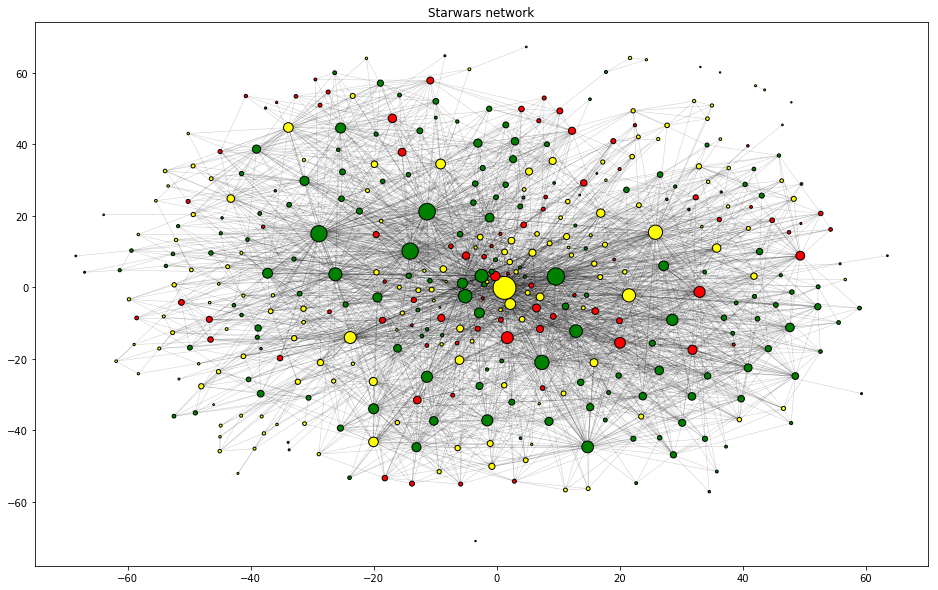

In [98]:
plt.figure(figsize=(16,10)) 

sizemap_degree = []
colormap = []
colors = ["red", "yellow", "green"]
for node in G_undir:
    sizemap_degree.append(G.degree(node, weight="weight") + 2)
    idx = 1
    if G.node[node]['goodness'] > 0:
        idx = 2
    elif G.node[node]['goodness'] < 0:
        idx = 0
    colormap.append(colors[idx])
nodelist = [node for node in G_undir.nodes]
edgelist = [edge for edge in G_undir.edges]
plt.title("Starwars network")
nx.draw_networkx_nodes(G_undir, positions, with_labels=False, nodelist=nodelist, node_color=colormap, edgecolors="black", node_size=sizemap_degree)
nx.draw_networkx_edges(G_undir, positions, alpha=0.2, edge_color="black", width=0.5, edgelist=edgelist)
plt.show()

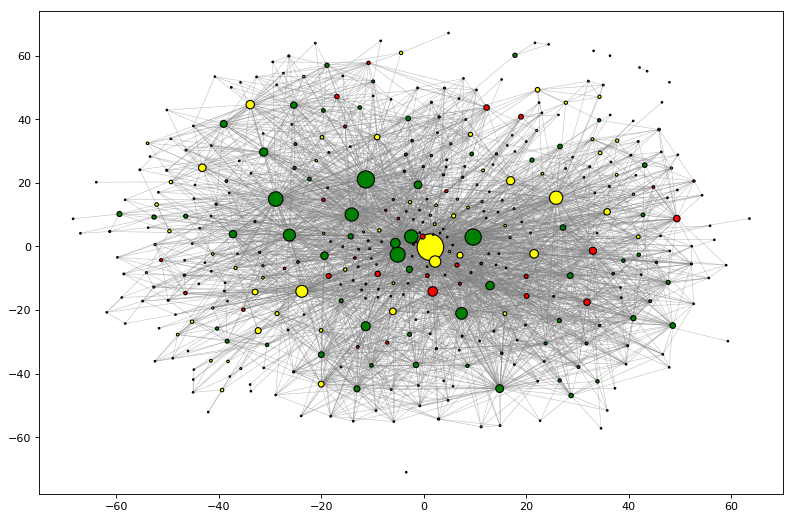

In [97]:
btw_cnt = nx.betweenness_centrality(G, weight="weight")

btw_cnt = list(map(lambda n: btw_cnt[n], nodelist))
plt.figure(num=None, figsize=(12, 8), dpi=80, facecolor='w', edgecolor='k')
scale_node = 3000
nx.draw_networkx_nodes(G_undir, positions, with_labels=False, nodelist=nodelist,
                       node_color=colormap, edgecolors="black", node_size=list(map(lambda x: 2+x*scale_node, btw_cnt)) )
nx.draw_networkx_edges(G_undir, positions, edge_color="gray", alpha=0.5, width=0.5)

plt.show()

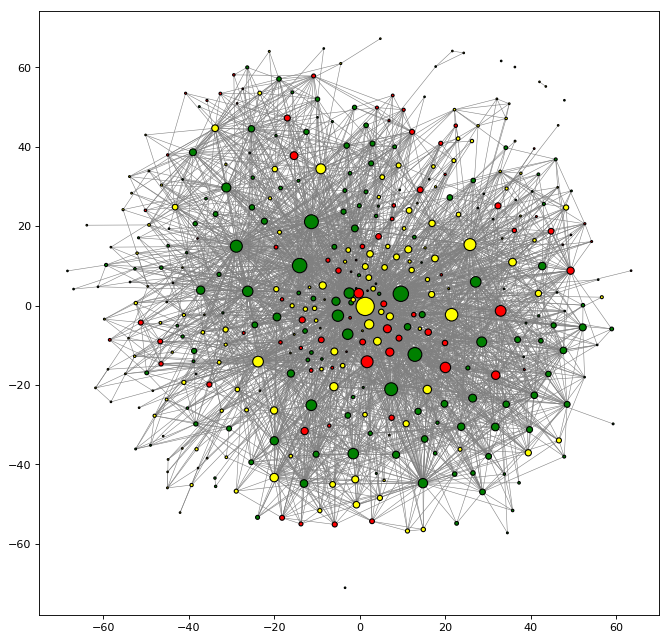

In [96]:
eig_cnt = nx.eigenvector_centrality(G, weight="weight")
eig_cnt = list(map(lambda n: eig_cnt[n], nodelist))

plt.figure(num=None, figsize=(10, 10), dpi=80, facecolor='w', edgecolor='k')
scale_node = 700
nx.draw_networkx_nodes(G_undir, positions, with_labels=False, nodelist=nodelist, node_color=colormap,
                       edgecolors="black", node_size=list(map(lambda x: 2+x*scale_node, eig_cnt)) )
nx.draw_networkx_edges(G_undir, positions, edge_color="gray", width=0.5)

plt.show()

In [88]:
degrees_names = sorted (G.nodes, key=lambda x: G.degree(x))
goodness_names = sorted (G.nodes, key=lambda x: G.node[x]['goodness'])